# Marketing Data Preparation

We will use this file to prepare our data before performing different analyses

In [1]:
# packages
import pandas as pd
import os
import warnings
from dotenv import load_dotenv
from google.cloud import bigquery
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
from google.cloud import bigquery
import db_dtypes

### Step 1: Data Ingestion
Read in our raw, unprocessed data from BQ

In [2]:
# retreive data from bigquery

load_dotenv()
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# initialize the BigQuery Client
client = bigquery.Client()

# BQ query
sql_query = """
    SELECT 
        *
    FROM `crudek-data.practice_data.marketing_campaign`             
"""

query_job = client.query(
    sql_query)

# retreive and convert the result to a Pandas DataFrame
df = query_job.to_dataframe()

Data Dictionary
- AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
- Complain - 1 if customer complained in the last 2 years
- DtCustomer - date of customer’s enrolment with the company
- Education - customer’s level of education
- Marital - customer’s marital status
- Kidhome - number of small children in customer’s household
- Teenhome - number of teenagers in customer’s household
- Income - customer’s yearly household income
- MntFishProducts - amount spent on fish products in the last 2 years
- MntMeatProducts - amount spent on meat products in the last 2 years
- MntFruits - amount spent on fruits products in the last 2 years
- MntSweetProducts - amount spent on sweet products in the last 2 years
- MntWines - amount spent on wine products in the last 2 years
- MntGoldProds - amount spent on gold products in the last 2 years
- NumDealsPurchases - number of purchases made with discount
- NumCatalogPurchases - number of purchases made using catalogue
- NumStorePurchases - number of purchases made directly in stores
- NumWebPurchases - number of purchases made through company’s web site
- NumWebVisitsMonth - number of visits to company’s web site in the last month
- Recency - number of days since the last purchase

### Step 2: Exploratory Data Analysis (EDA)

In [3]:
# quick view and shape (rows, cols)
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1386,1967,Graduation,Together,32474.0,1,1,2014-05-11,0,10,...,7,0,0,0,0,0,0,3,11,0
1,2724,1981,Master,Single,36143.0,1,0,2014-03-30,33,12,...,3,0,0,0,0,0,0,3,11,0
2,8461,1962,Graduation,Divorced,46102.0,2,1,2014-03-10,3,14,...,7,0,0,0,0,0,0,3,11,0
3,5824,1972,PhD,Together,34578.0,2,1,2014-04-11,1,7,...,6,0,0,0,0,0,0,3,11,0
4,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,...,14,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10619,1994,Graduation,Single,95529.0,0,0,2012-12-03,29,770,...,3,0,0,1,0,0,0,3,11,1
2236,2008,1978,Graduation,Married,77583.0,0,0,2014-02-10,93,372,...,2,0,0,0,1,0,0,3,11,0
2237,7428,1975,Graduation,Together,80144.0,0,0,2013-09-30,47,240,...,1,0,0,0,0,0,0,3,11,0
2238,5453,1956,Master,Married,90226.0,0,0,2012-09-26,26,1083,...,2,0,0,0,1,0,0,3,11,0


In [4]:
# quick check for duplicates
df.duplicated().sum()

0

In [5]:
# summary statisitics, data types and missing values

# unique values for each column
df_uniq_cols = df.nunique().reset_index()
df_uniq_cols.columns = ['column', 'num_unique']

# summary statistics
df_stats = df.describe().transpose().reset_index()
df_stats.rename(columns={'index': 'column'}, inplace=True)

# data types for each column
df_dtypes = df.dtypes.reset_index()
df_dtypes.columns = ['column', 'data_type']

# missing values for each column
df_nulls = df.isna().sum().reset_index()
df_nulls.columns = ['column', 'num_nulls']

# merge the above together
df_combined = pd.merge(df_uniq_cols, df_dtypes, on='column', how='outer')
df_combined = pd.merge(df_combined, df_nulls, on='column', how='outer')
df_combined = pd.merge(df_combined, df_stats, on='column', how='outer')

# sort by 'num_unique' column
df_sorted = df_combined.sort_values(by='num_unique', ascending=False)

# --------------------------------------------------------------------------------- #

# first 3 values for each col
first_three_df = df.apply(lambda x: pd.Series(x.head(3).values)).reset_index()

# melt to 2 columns
melted_df = first_three_df.melt(var_name='column', value_name='value')

# assign a new column to indicate the value index
melted_df['val_index'] = melted_df.groupby('column').cumcount() + 1

# pivot the melted DataFrame
reshaped_df = melted_df.pivot(index='column', columns='val_index', values='value')

# rename the columns
reshaped_df.columns = ['first_val', 'second_val', 'third_val']

# reset the index to turn 'column' into a regular column
reshaped_df.reset_index(inplace=True)

# --------------------------------------------------------------------------------- #

# final joined df for initial eda
df_investigate = pd.merge(df_sorted, reshaped_df, on='column', how='inner')

df_investigate

,column,num_unique,data_type,num_nulls,count,mean,std,min,25%,50%,75%,max,first_val,second_val,third_val
0,ID,2240,Int64,0,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0,1386,2724,8461
1,Income,1974,float64,24,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0,32474.0,36143.0,46102.0
2,MntWines,776,Int64,0,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0,10,12,14
3,Dt_Customer,663,object,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-11,2014-03-30,2014-03-10
4,MntMeatProducts,558,Int64,0,2240.0,166.95,225.715373,0.0,16.0,67.0,232.0,1725.0,1,1,1
5,MntGoldProds,213,Int64,0,2240.0,44.021875,52.167439,0.0,9.0,24.0,56.0,362.0,0,6,1
6,MntFishProducts,182,Int64,0,2240.0,37.525446,54.628979,0.0,3.0,12.0,50.0,259.0,0,0,0
7,MntSweetProducts,177,Int64,0,2240.0,27.062946,41.280498,0.0,1.0,8.0,33.0,263.0,0,0,0
8,MntFruits,158,Int64,0,2240.0,26.302232,39.773434,0.0,1.0,8.0,33.0,199.0,0,0,0
9,Recency,100,Int64,0,2240.0,49.109375,28.962453,0.0,24.0,49.0,74.0,99.0,0,33,3


Intial Review
- We can remove ```ID``` as it does not provide relevant information for anlysis
- ```Income``` has 24 missing values which will need to be handled (imputation)
- We can remove ```Z_CostContact``` and ```Z_Revenue``` given they are all the same values
-  ```Education```, ```Marital_Status``` and ```Dt_Customer``` are categorical so need to be handled (encoding)

In [6]:
# remove the fields mentioned above before moving on to next steps
df2 = df.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'])

In [7]:
# although we will feature engineer in later steps, let's create a couple date-related calcs

# given this is a stale dataset that hasn't been updated in ~4 years (as of 2024), we will assume this analysis is taking place on January 1st, 2020
    # if this were not the case, we could replace 'datetime(2020, 1, 1)' with 'datetime.now()'

# 1. age of the customer
df2['customer_age'] = datetime(2020, 1, 1).year - df['Year_Birth']

# 2. how long customer has been enrolled
df2['days_since_enroll'] = (datetime(2020, 1, 1) - pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')).dt.days

df2 = df2.drop(columns=['Dt_Customer', 'Year_Birth'])

### Step 3: Handle Missing Data

Impute missing values for ```Income```

In [8]:
# replace null values of income with the average income by each education type
df2['income_clean'] = df2['Income'].fillna(df.groupby('Education')['Income'].transform('mean'))
df2 = df2.drop('Income', axis=1) # remove Income column with missing values

### Step 4: Handle Outliers

This step could look different based on the business problem/circumstances and any additional domain knowledge

In [9]:
# list of numerical columns
numerical_columns = df2.select_dtypes(include=['number']).columns.tolist()

# unique values for each column
df2_uniq_cols = df2[numerical_columns].nunique().reset_index()
df2_uniq_cols.columns = ['column', 'num_unique']
df2_uniq_cols.sort_values(by='num_unique', ascending=False)

,column,num_unique
23,income_clean,1978
3,MntWines,776
22,days_since_enroll,663
5,MntMeatProducts,558
8,MntGoldProds,213
6,MntFishProducts,182
7,MntSweetProducts,177
4,MntFruits,158
2,Recency,100
21,customer_age,59


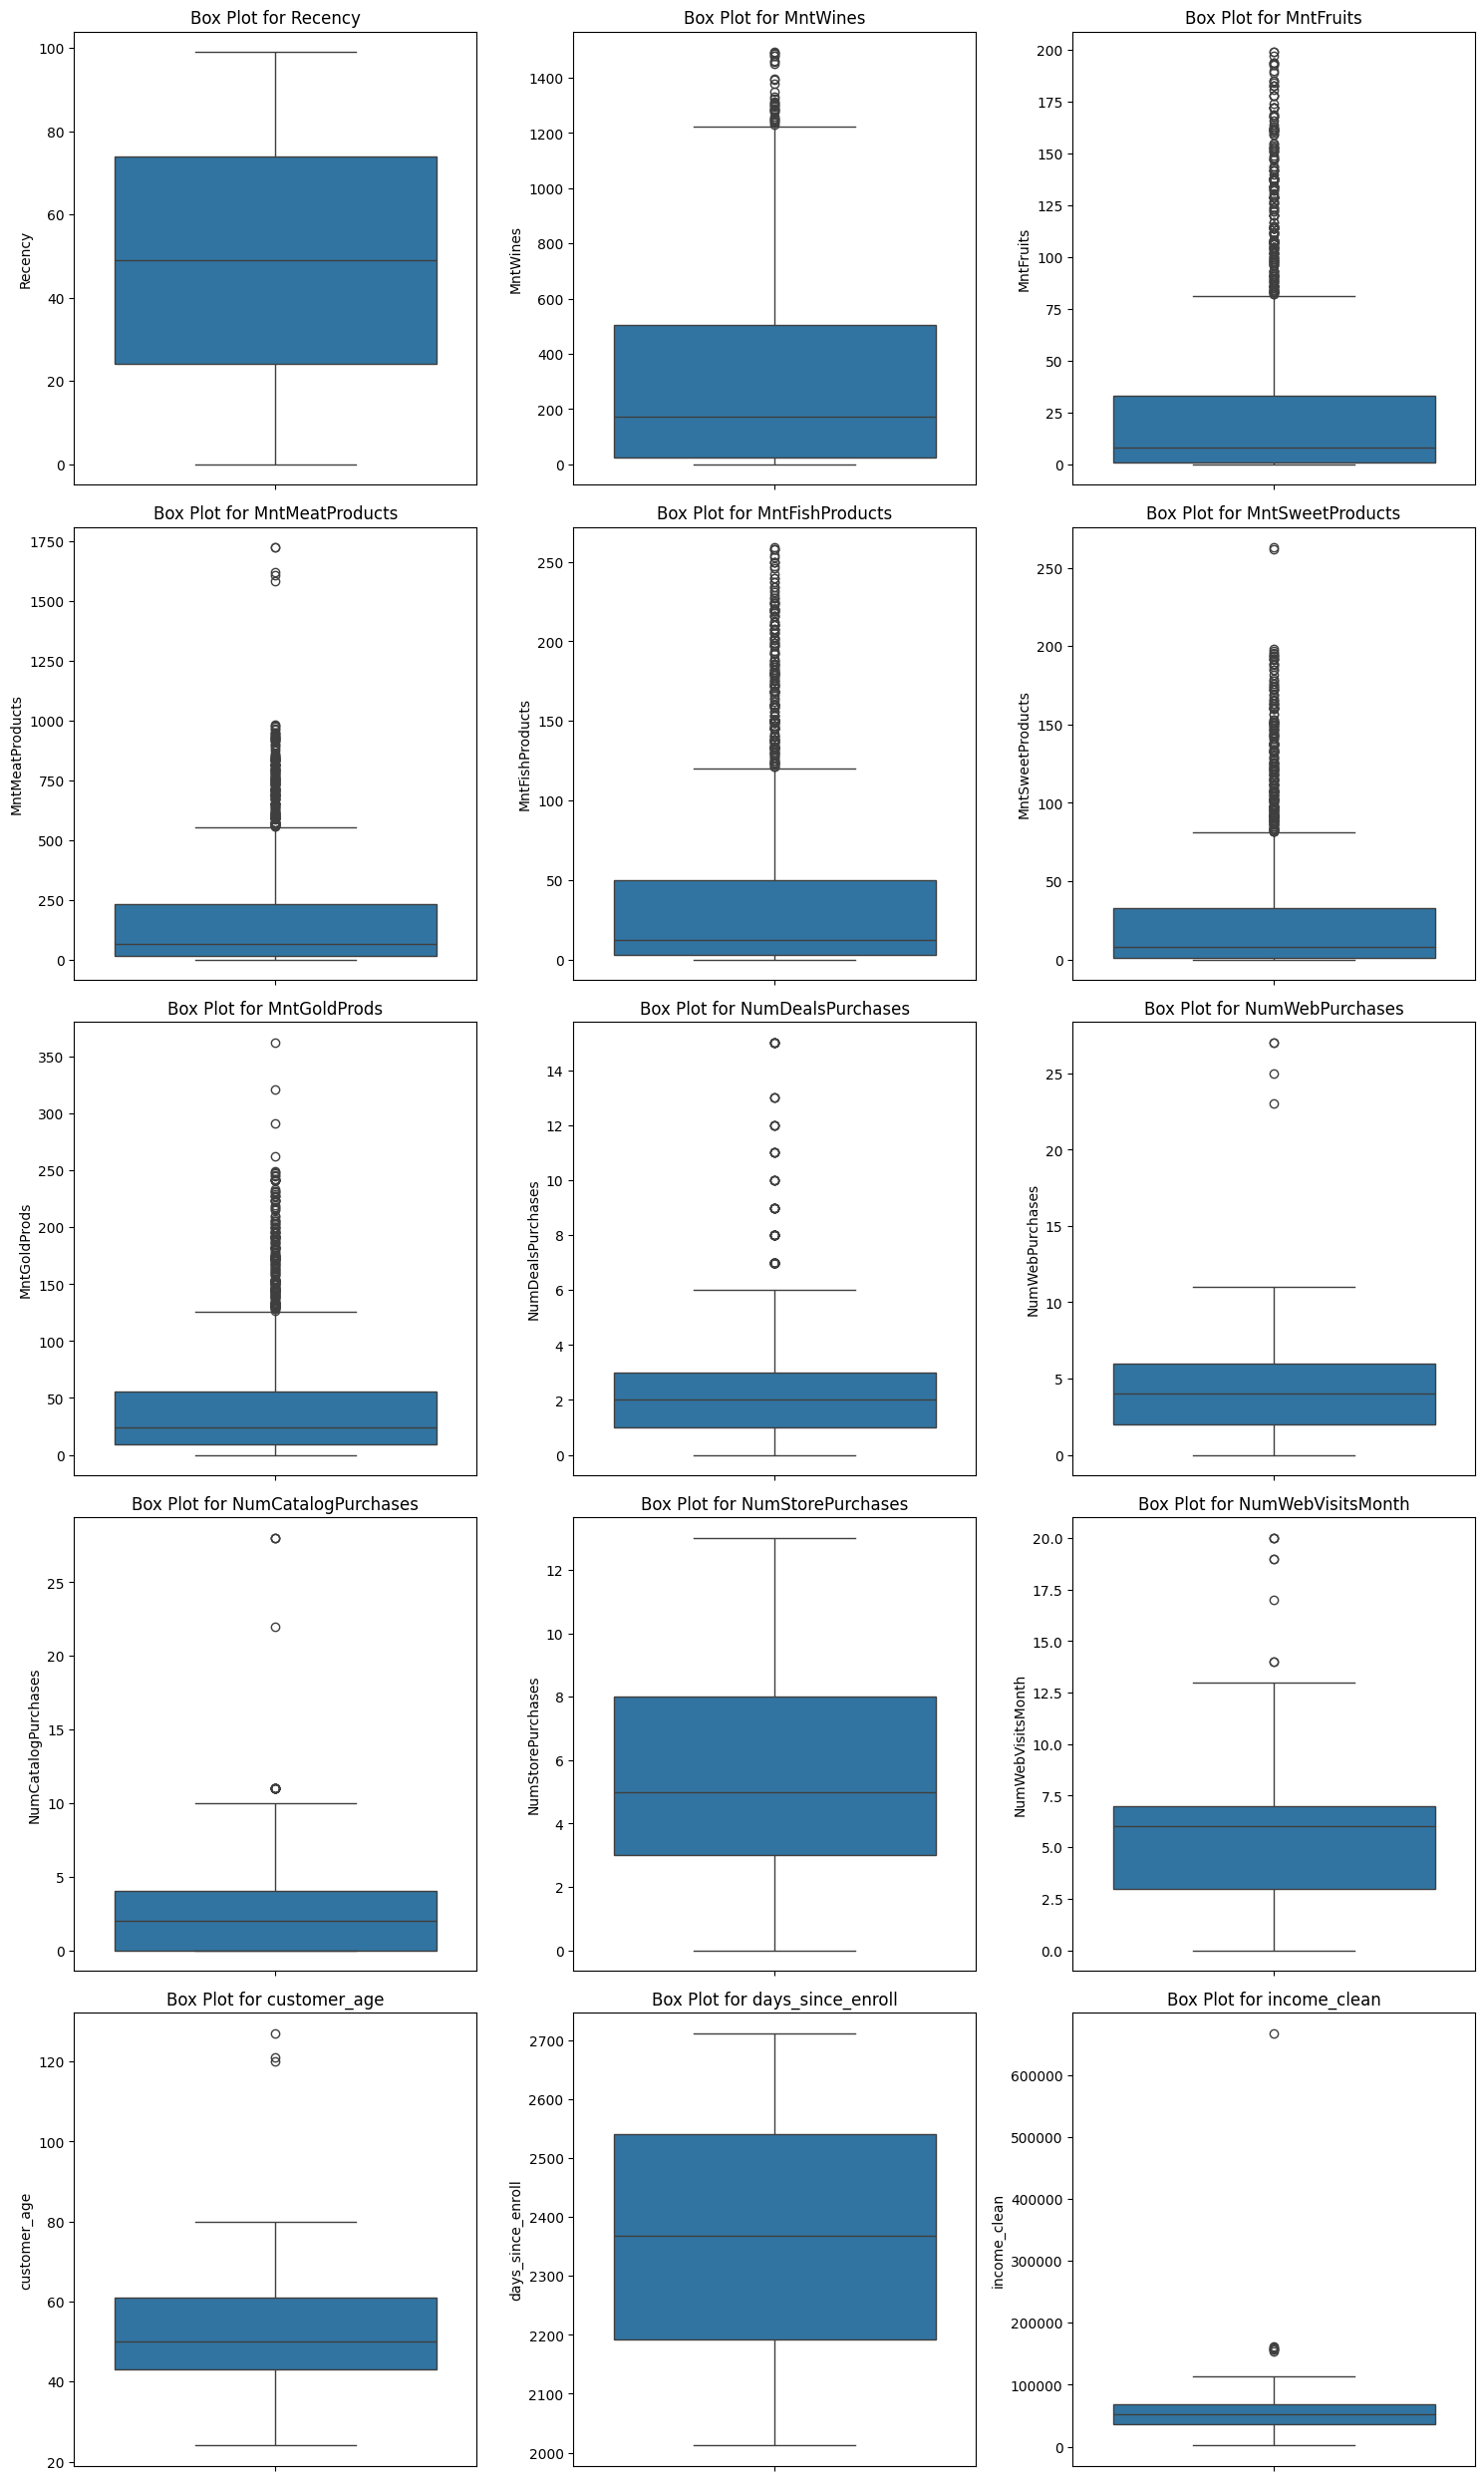

In [10]:
# create boxplots for our numerical columns

# we aren't interested in columns with extremely low variance
cols_of_interest = df2_uniq_cols[df2_uniq_cols['num_unique'] > 3]

cols_list = cols_of_interest['column'].tolist()

# df for box plots
init_outlier_df = df2[cols_list]

# --------------------------------------------------------------------------------- #

# set the number of rows and columns for the grid layout
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_list) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# set up the matplotlib figure
plt.figure(figsize=(15, n_rows * 5))  # adjust height based on the number of rows

# loop through numerical columns and create box plots
for i, col in enumerate(cols_list):
    plt.subplot(n_rows, n_cols, i + 1)  # create a subplot for each column
    sns.boxplot(y=init_outlier_df[col])  # create a box plot
    plt.title(f'Box Plot for {col}')  # set the title
    plt.xlabel('')  # remove x-axis label for clarity

plt.tight_layout()  # adjust the layout
plt.show()  # display plots

In [11]:
# function to calculate Z-scores
def calculate_z_scores(df):
    z_scores = (df - df.mean()) / df.std()
    return z_scores

# calculate Z-scores for numerical columns
z_scores = calculate_z_scores(df2[cols_list])

# determine the threshold for outliers
threshold = 3

# create a DataFrame to indicate outliers
outlier_mask = (z_scores.abs() > threshold).astype(int)
outlier_mask.columns = [f"{col}_outlier" for col in outlier_mask]

# combine with the original DataFrame
df_outliers = pd.concat([init_outlier_df, outlier_mask], axis=1)
df_outliers

# display rows that are outliers in any numerical column
outlier_rows = df_outliers[(df_outliers.filter(like='_outlier').sum(axis=1) > 0)]  # Select rows with any outlier

# display the DataFrame with outliers marked
#outlier_rows

# create summary dictionary for sums and counts
outlier_summary = {}
for col in outlier_rows.columns:
    if col.endswith('_outlier'):
        original_col = col.replace('_outlier', '')
        
        # Sum of outliers
        sum_of_outliers = outlier_rows[original_col][outlier_rows[col] == 1].sum()
        
        # Count of outlier rows
        count_of_outliers = outlier_rows[col].sum()  # Since it's binary, sum gives the count

        outlier_summary[col] = {'Sum': sum_of_outliers, 'Count': count_of_outliers}

# convert the summary dictionary to a DataFrame for better readability
outlier_summary_df = pd.DataFrame.from_dict(
    {col: {'Sum of Outliers': values['Sum'], 'Count of Outliers': values['Count']} for col, values in outlier_summary.items()},
    orient='index'
)

# display the summary DataFrame
print(outlier_summary_df.sort_values(by='Count of Outliers', ascending=False))


                             Sum of Outliers  Count of Outliers
MntFruits_outlier                    10779.0                 64
MntSweetProducts_outlier             10833.0                 62
MntFishProducts_outlier              13084.0                 58
MntGoldProds_outlier                 10295.0                 44
MntMeatProducts_outlier              37497.0                 37
NumDealsPurchases_outlier              369.0                 32
MntWines_outlier                     22778.0                 16
NumWebVisitsMonth_outlier              156.0                  9
income_clean_outlier               1772836.0                  8
NumWebPurchases_outlier                102.0                  4
NumCatalogPurchases_outlier            106.0                  4
customer_age_outlier                   368.0                  3
Recency_outlier                          0.0                  0
NumStorePurchases_outlier                0.0                  0
days_since_enroll_outlier               

Baed on our boxplots and Z-score exercise, I am only going to dfocus on the one large income of $666,666 and the customers with ages 127, 121 and 120. \
\
There are several techniques for handling outliers. I am choosing to not remove these records, but instead use *Winsorizing* which caps these extreme values.

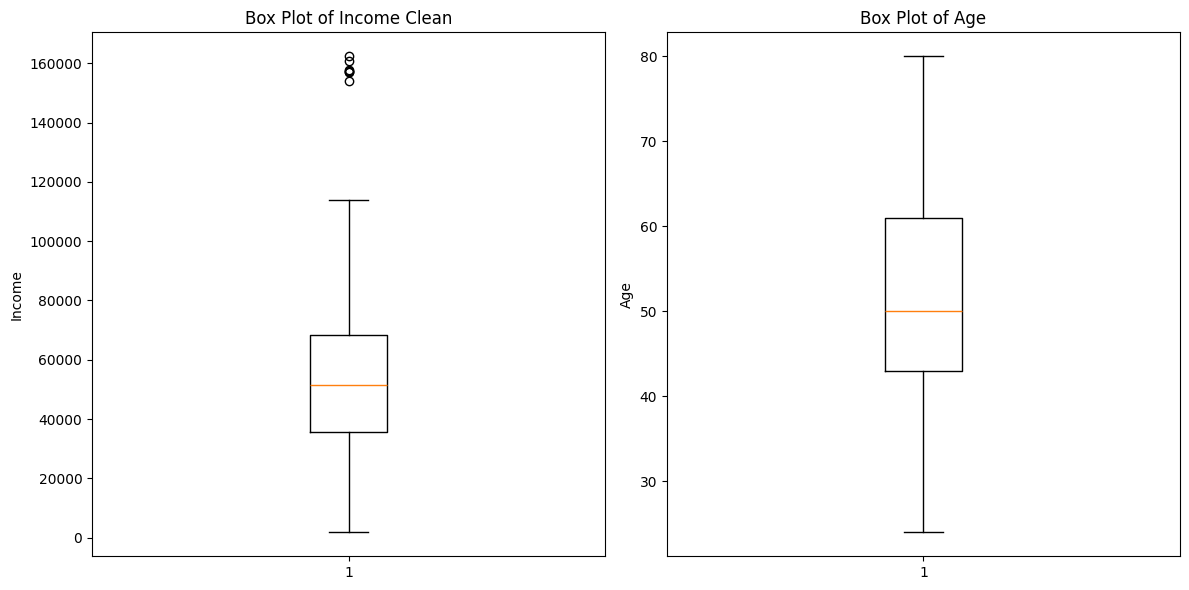

In [12]:
df3 = df2.copy()

df3[numerical_columns] = df3[numerical_columns].astype(float)

# define the condition for Winsorizing
condition_income = df3['income_clean'] > 500000
condition_age = df3['customer_age'] > 100

# combine conditions
condition = condition_income | condition_age

# perform Winsorizing for the relevant columns
# adjust limits (0.05, 0.95) based on your requirements for lower and upper bounds
for column in ['income_clean', 'customer_age']:
    df3.loc[condition, column] = mstats.winsorize(df3.loc[condition, column], limits=[0.05, 0.95])

# create box plots
plt.figure(figsize=(12, 6))

# bp for income_clean
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.boxplot(df3['income_clean'])
plt.title('Box Plot of Income Clean')
plt.ylabel('Income')

# bp for age
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.boxplot(df3['customer_age'])
plt.title('Box Plot of Age')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

Now we can see our boxplots do not contain the large outliers

### Step 5: Feature Engineering

In [13]:
warnings.filterwarnings('ignore') # Suppress all warnings

df4 = df3.copy()

# simplify relationship statuses
def relationship(Marital_Status):
    if Marital_Status in ['Single', 'Alone', 'Absurd', 'YOLO']:
        return 'single'
    elif Marital_Status in ['Together', 'Married']:
        return 'current'
    else:
        return 'previous'
df4['relationship_status'] = df4['Marital_Status'].apply(relationship)  
    
# simplify education levels
def education(Education):
    if Education in ['Basic', 'Graduation']:
        return 'low'
    elif Education in ['Master', '2n Cycle']:
        return 'medium'
    else:
        return 'high'
df4['education_lvl'] = df4['Education'].apply(education) 

# total number of campaigns accepted
df4['accepted_campaigns'] = df4['AcceptedCmp1'] + df4['AcceptedCmp2'] + df4['AcceptedCmp3'] + df4['AcceptedCmp4'] + df4['AcceptedCmp5']

# total amount spent across all products in the last 2 years
df4['amount_spent'] = df4['MntFishProducts'] + df4['MntMeatProducts'] + df4['MntFruits'] + df4['MntSweetProducts'] + df4['MntWines'] + df4['MntGoldProds']

# dependents
df4['dependents'] = df4['Kidhome'] + df4['Teenhome']


# remove unneeded fields
df5 = df4.drop(columns=['Education', 'Kidhome', 'Teenhome', 'Marital_Status'])

df5

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,Complain,Response,customer_age,days_since_enroll,income_clean,relationship_status,education_lvl,accepted_campaigns,amount_spent,dependents
0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,53.0,2061.0,32474.0,current,low,0.0,11.0,2.0
1,33.0,12.0,0.0,1.0,0.0,0.0,6.0,1.0,0.0,1.0,...,0.0,0.0,39.0,2103.0,36143.0,single,medium,0.0,19.0,1.0
2,3.0,14.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,58.0,2123.0,46102.0,previous,low,0.0,16.0,3.0
3,1.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,48.0,2091.0,34578.0,current,high,0.0,8.0,3.0
4,56.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,47.0,2454.0,3502.0,single,low,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,29.0,770.0,29.0,890.0,250.0,27.0,24.0,1.0,7.0,3.0,...,0.0,1.0,26.0,2585.0,95529.0,single,low,1.0,1990.0,0.0
2236,93.0,372.0,23.0,384.0,250.0,12.0,108.0,1.0,4.0,5.0,...,0.0,0.0,42.0,2151.0,77583.0,current,low,1.0,1149.0,0.0
2237,47.0,240.0,132.0,445.0,250.0,192.0,108.0,1.0,3.0,7.0,...,0.0,0.0,45.0,2284.0,80144.0,current,low,0.0,1367.0,0.0
2238,26.0,1083.0,108.0,649.0,253.0,151.0,108.0,1.0,4.0,7.0,...,0.0,0.0,64.0,2653.0,90226.0,current,medium,1.0,2352.0,0.0


In [14]:
# Rename some fields to match original capitalization 
df6 = df5.copy()
df6.rename(columns={'customer_age': 'CustomerAge', 'days_since_enroll': 'DaysEnrolled','income_clean': 'Income', 'relationship_status': 'Relationship',
                    'education_lvl': 'Education', 'accepted_campaigns': 'TotalAcceptedCampaigns',
                    'amount_spent': 'TotalAmountSpent', 'dependents': 'Dependents'}, inplace=True)

df6


,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,...,Complain,Response,CustomerAge,DaysEnrolled,Income,Relationship,Education,TotalAcceptedCampaigns,TotalAmountSpent,Dependents
0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,53.0,2061.0,32474.0,current,low,0.0,11.0,2.0
1,33.0,12.0,0.0,1.0,0.0,0.0,6.0,1.0,0.0,1.0,...,0.0,0.0,39.0,2103.0,36143.0,single,medium,0.0,19.0,1.0
2,3.0,14.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,58.0,2123.0,46102.0,previous,low,0.0,16.0,3.0
3,1.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,48.0,2091.0,34578.0,current,high,0.0,8.0,3.0
4,56.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,47.0,2454.0,3502.0,single,low,0.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,29.0,770.0,29.0,890.0,250.0,27.0,24.0,1.0,7.0,3.0,...,0.0,1.0,26.0,2585.0,95529.0,single,low,1.0,1990.0,0.0
2236,93.0,372.0,23.0,384.0,250.0,12.0,108.0,1.0,4.0,5.0,...,0.0,0.0,42.0,2151.0,77583.0,current,low,1.0,1149.0,0.0
2237,47.0,240.0,132.0,445.0,250.0,192.0,108.0,1.0,3.0,7.0,...,0.0,0.0,45.0,2284.0,80144.0,current,low,0.0,1367.0,0.0
2238,26.0,1083.0,108.0,649.0,253.0,151.0,108.0,1.0,4.0,7.0,...,0.0,0.0,64.0,2653.0,90226.0,current,medium,1.0,2352.0,0.0


### Finished, for now
We can write our cleaned up dataset back to BQ and then we can use that in future analyses. We will wait to perform any categorical variable encoding and numerical scaling as it may not be neccessary for some algorithms

In [15]:

# used for both BQ read/write

# setting environmental variable directly in your code
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'bq-crudek-data.json'

# initialize the BigQuery Client
client = bigquery.Client()

# set table_id to the ID of the table to create
table_id = 'crudek-data.practice_data.marketing_campaign_clean'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("Relationship", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("Education", bigquery.enums.SqlTypeNames.STRING),
    ],
    write_disposition="WRITE_TRUNCATE",
)

# make API request
job = client.load_table_from_dataframe(
    df6, table_id, job_config=job_config
)  
# wait for the job to complete.
job.result()  


LoadJob<project=crudek-data, location=US, id=9afb510e-9749-48c6-8b74-2e7165f2a14e>

In [16]:
# confirm with shape
table = client.get_table(table_id)
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 2240 rows and 27 columns to crudek-data.practice_data.marketing_campaign_clean
